# 1 ) DEFINICIÓN DEL PROYECTO DE MACHINE LEARNING

## **TÍTULO**

### **Optimización de modelos operativos en Telecom: Análisis Profundo de los contactos para Mejorar el CX**

## **TEMA**

##### **En este proyecto, llevaremos a cabo un análisis exhaustivo de las interacciones de los clientes con Telecom. Nuestro objetivo es descubrir insights a partir de un análisis profundo de los datos, correlacionando los mismo buscamos desarrollar conclusiones significativas, que no solo logren esclarecer  patrones de comportamiento de los clientes, sino que también proporcionen orientación para mejorar la experiencia del cliente de manera significativa.**

#### **El objetivo preponderante es dimensionar la demanda en volumen de llamados mediante un modelo predictivo de series temporales con una regresion lineal.

## **OBTENCIÓN DE LOS DATOS**

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

### Mi BBDD 5.000.- interacciones es obtenida desde una fuente pública:

 https://www.kaggle.com/datasets/datazng/telecom-company-churn-rate-call-center-data

# 2) IMPORTACIÓN DE LIBRERIAS

In [7]:
# PARA EL TRATAMIENTO DE LOS DATOS Y MODELOS PREDICTIVOS
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from warnings import simplefilter
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
simplefilter("ignore")

## IMPORTAMOS LA FUENTE PARA LAS FIGURAS

In [8]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

## IMPORTACIÓN DEL DATASET 

In [9]:
dataset = r"C:\Users\Lucia\Desktop\PROYECTO_MLP_PABLO_XAVIER\PROYECTO_MLP_PABLO_XAVIER_MENDEZ\src\data\process\telecom.csv"
df = pd.read_csv(dataset, parse_dates=['DATE'])

### CREACION DE UN NUEVO DATAFRAME CON EL DETALLE DE LA CANTIDAD DE LLAMADAS POR DÍA

In [10]:
calls_per_date = df.groupby("DATE").size()

calls_per_date_df = pd.DataFrame(calls_per_date, columns=["CALLS"])

calls_per_date_df

,CALLS
DATE,
2021-01-01,58
2021-01-02,60
2021-01-03,58
2021-01-04,54
2021-01-05,56
...,...
2021-03-27,58
2021-03-28,38
2021-03-29,60


### Generación del index

In [11]:
calls_per_date_df['time'] = np.arange(len(calls_per_date_df.index))

calls_per_date_df.head()

,CALLS,time
DATE,,
2021-01-01,58,0
2021-01-02,60,1
2021-01-03,58,2
2021-01-04,54,3
2021-01-05,56,4


In [12]:
calls_per_date_df = pd.DataFrame(calls_per_date, columns=["CALLS"])

calls_per_date_df.index = pd.to_datetime(calls_per_date_df.index).to_period('D')

print(calls_per_date_df)

            CALLS
DATE             
2021-01-01     58
2021-01-02     60
2021-01-03     58
2021-01-04     54
2021-01-05     56
...           ...
2021-03-27     58
2021-03-28     38
2021-03-29     60
2021-03-30     25
2021-03-31     27

[90 rows x 1 columns]


### Aplicamos un grafico de medias moviles

<Axes: title={'center': 'llamadas diarias - 90 -Day Moving Average'}, xlabel='DATE'>

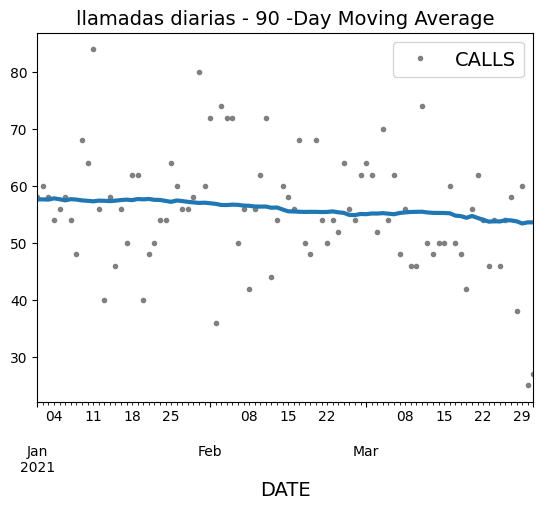

In [13]:
moving_average = calls_per_date_df.rolling(
    window=90,       
    center=True,      
    min_periods=45,  
).mean()              

ax = calls_per_date_df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="llamadas diarias - 90 -Day Moving Average", legend=False,)

In [14]:


dp = DeterministicProcess(
    index=calls_per_date_df.index,  
    constant=True,       # característica dummy para el sesgo (y_intercept)
    order=1,             # la variable ficticia del tiempo (tendencia)
    drop=True,           # elimine términos si es necesario para evitar colinealidad
)
# `in_sample` crea características para las fechas dadas en el argumento `index
X = dp.in_sample()

X.head()

,const,trend
DATE,,
2021-01-01,1.0,1.0
2021-01-02,1.0,2.0
2021-01-03,1.0,3.0
2021-01-04,1.0,4.0
2021-01-05,1.0,5.0


In [15]:
from sklearn.linear_model import LinearRegression

y = calls_per_date_df["CALLS"]

# La intercepción es el mismo que el `const` característica de
# DeterministicProcess. LinearRegression se comporta mal con 
# características duplicadas, por lo que necesitamos estar seguros de excluirlos.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

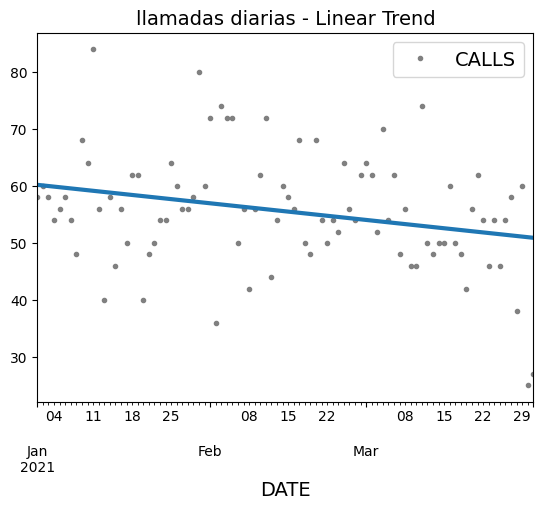

In [16]:
ax = calls_per_date_df.plot(style=".", color="0.5", title="llamadas diarias - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [17]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2021-04-01    50.802747
2021-04-02    50.698289
2021-04-03    50.593832
2021-04-04    50.489375
2021-04-05    50.384917
Freq: D, dtype: float64

In [18]:
calls_per_date_df

,CALLS
DATE,
2021-01-01,58
2021-01-02,60
2021-01-03,58
2021-01-04,54
2021-01-05,56
...,...
2021-03-27,58
2021-03-28,38
2021-03-29,60


### Aplicamos una parte de la serie para ver la tendencia prevista para los próximos 30 días:

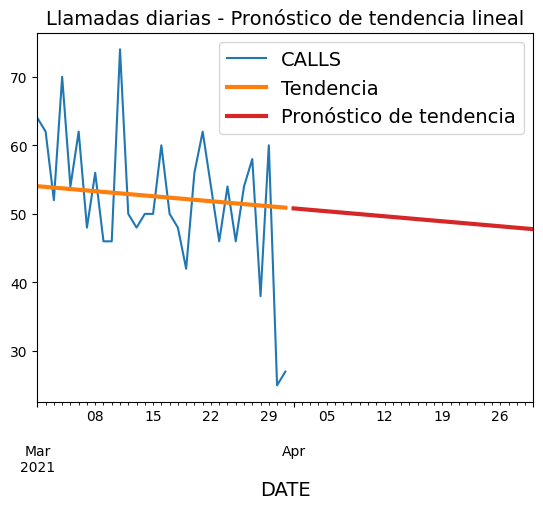

In [19]:
calls_april = calls_per_date_df["2021-03":]
y_pred_april = y_pred["2021-03":]
y_fore_april = y_fore["2021-03":]

# Configurar parámetros de gráfico
plot_params = {
    "kind": "line",
    "title": "Llamadas diarias - Pronóstico de tendencia lineal"
}

# Crear gráfico
ax = calls_april.plot(**plot_params)
ax = y_pred_april.plot(ax=ax, linewidth=3, label="Tendencia")
ax = y_fore_april.plot(ax=ax, linewidth=3, label="Pronóstico de tendencia", color="C3")

# Mostrar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse = mean_squared_error(calls_per_date_df['CALLS'], y_pred)
print("Mean Squared Error (MSE):", mse)
mae = mean_absolute_error(calls_per_date_df['CALLS'], y_pred)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(calls_per_date_df['CALLS'], y_pred)
print("R cuadrado (R^2):", r2)

Mean Squared Error (MSE): 94.14933774783964
Mean Absolute Error (MAE): 7.311974500738553
R cuadrado (R^2): 0.07254440717352051


In [21]:
print(model.coef_)
print(model.intercept_)

[60.30836454 -0.10445734]
0.0


In [23]:
from sklearn.linear_model import LinearRegression
import pickle

# Crea y entrena el modelo
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Guarda el modelo en un archivo pickle
with open('modelo_linear_regression.pkl', 'wb') as f:
    pickle.dump(model, f)

ValueError: Found input variables with inconsistent numbers of samples: [30, 90]